In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## Load data

In [3]:
path = 'yelp_data/health_text_sentiment.csv'
df = pd.read_csv(path)
df.drop(['Unnamed: 0'],axis=1,inplace=True)

data = df[['stars','text','clean_text']]

In [4]:
data.head()

,stars,text,clean_text
0,1,Please stay away from this place if you can! I...,please stay away place bad care imaginable sta...
1,5,My husband has been a patient of Dr. Byrne for...,husband patient dr byrne last year half last m...
2,4,Dr. Byrne is a great doctor! She has great bed...,dr byrne great doctor great bed side manner ex...
3,3,I'm raising my review as Dr Bryne's has been m...,raise review dr bryne receptive daughter go an...
4,1,I wish I could give 0 stars. Worst office I've...,wish could give star bad office ever horrible ...


## Select 1& 5 stars only

In [5]:
data = data.ix[np.where((data.stars==1)|(data.stars==5))]
data.head()

,stars,text,clean_text
0,1,Please stay away from this place if you can! I...,please stay away place bad care imaginable sta...
1,5,My husband has been a patient of Dr. Byrne for...,husband patient dr byrne last year half last m...
4,1,I wish I could give 0 stars. Worst office I've...,wish could give star bad office ever horrible ...
5,1,I went to the emergency room because i was hav...,go emergency room kidney stone attack emergenc...
6,5,Dr. Byrne is an excellent doctor with all the ...,dr byrne excellent doctor right skill include ...


## binary stars

In [ ]:
data.stars.replace(1,0,inplace=True)
data.stars.replace(5,1,inplace=True)

In [ ]:
data.head()

# Logistic Regression

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,recall_score,precision_score

In [10]:
review = data['text'].values.astype(str)  # original review
review_clean = data['clean_text'].values.astype(str)  # clean text review
sentiments = data['stars'].values  # star value

## create function for speed

In [42]:
def nlp_LogisticRegression_cv(X,y,nrange=0):
    '''func '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    if nrange== 0:
        vectorizer = CountVectorizer()
    else:
        vectorizer = CountVectorizer(ngram_range=nrange)

    
    count_train = vectorizer.fit_transform(X_train)
    count_test = vectorizer.transform(X_test)
    
    classifier = LogisticRegression()

    # Train the classifier
    classifier.fit(count_train, y_train)  # we fit with the X_train_vectorized, not original X_train

    # Check our classifier performance
    score = classifier.score(count_test, y_test)
    return score

In [56]:
def nlp_LogisticRegression_tf(X,y,nrange=0,max_df=1.0):
    '''func '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    if nrange== 0:
        vectorizer = TfidfVectorizer(max_df=max_df)
    else:
        vectorizer = TfidfVectorizer(max_df=max_df, ngram_range=nrange)

    tfidf_train = vectorizer.fit_transform(X_train)
    tfidf_test = vectorizer.transform(X_test)
    
    
    classifier = LogisticRegression()

    # Train the classifier
    classifier.fit(tfidf_train, y_train)  # we fit with the X_train_vectorized, not original X_train

    # Check our classifier performance
    score = classifier.score(tfidf_test, y_test)
    return score

## original text vs clean text

In [44]:
%%time
original_cv = nlp_LogisticRegression_cv(review, sentiments)

print(original_cv)

0.9710030463725601
CPU times: user 1min 18s, sys: 9.67 s, total: 1min 28s
Wall time: 19 s


In [57]:
%%time
original_tf = nlp_LogisticRegression_tf(review, sentiments)
print(original_tf)

0.9698747602391966
CPU times: user 16.7 s, sys: 2.77 s, total: 19.4 s
Wall time: 10.2 s


## max_df values

In [ ]:
dfrq_range = np.arange(0.1,1.1,0.1)
dfrq_range = np.around(doc_frq, decimals=2)

In [115]:
%%time
doc_frq_results = {}
for dfq in dfrq_range:
    if dfq in doc_frq_results:
        doc_frq_results[dfq].append(nlp_LogisticRegression_tf(review, sentiments,max_df = dfq))
    else:
        doc_frq_results[dfq] = nlp_LogisticRegression_tf(review, sentiments,max_df = dfq)

CPU times: user 2min 45s, sys: 26.4 s, total: 3min 11s
Wall time: 1min 43s


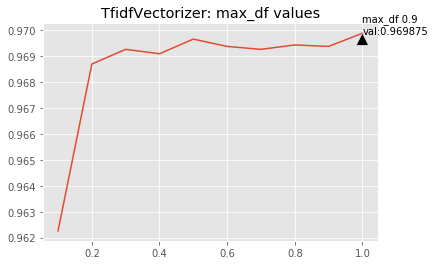

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111)

x=list(doc_frq_results.keys())
y=list(doc_frq_results.values())
line, = ax.plot(x, y)

ymax = max(y)
xpos = y.index(ymax)
xmax = x[xpos]
value = 'max_df 0.{}\nval:{:3f}'.format(xpos,ymax)
ax.annotate(value, xy=(xmax, ymax),
            arrowprops=dict(facecolor='black'),
            )
plt.title('TfidfVectorizer: max_df values')
plt.show()

## Score

## Ngrams instead of Words

In [140]:
%%time
original_cv_ngram_13 = nlp_LogisticRegression_cv(review, sentiments,(1,3))
print(original_cv_ngram_13)
print('-----------------------')

0.9754033622926774
-----------------------
CPU times: user 4min 42s, sys: 30.3 s, total: 5min 12s
Wall time: 1min 42s


In [141]:
%%time
original_tf_ngram_13 = nlp_LogisticRegression_tf(review, sentiments,(1,3))
print(original_tf_ngram_13)
print('-----------------------')

0.9667155590657791
-----------------------
CPU times: user 1min 35s, sys: 10.5 s, total: 1min 46s
Wall time: 1min 8s


## Pipeline

In [48]:
from sklearn.pipeline import Pipeline

In [49]:
review = data['text'].values.astype(str)  # original review
review_clean = data['clean_text'].values.astype(str)  # clean text review
sentiments = data['stars'].values  # star value

## CountVectorizer

In [50]:
%%time
X_train, X_test, y_train, y_test = train_test_split(review, sentiments, test_size=0.33, random_state=42)
# Put everything in a Pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 3))),
    ('classifier', LogisticRegression())])

pipeline.fit(X_train, y_train)
# Check our classifier performance

score = pipeline.score(X_test, y_test)

print("Accuracy=", score)
print('-----------------------')

Accuracy= 0.9754033622926774
CPU times: user 4min 44s, sys: 30.2 s, total: 5min 14s
Wall time: 1min 42s


## tfidf

In [51]:
%%time
X_train, X_test, y_train, y_test = train_test_split(review, sentiments, test_size=0.33, random_state=42)
# Put everything in a Pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
    ('classifier', LogisticRegression())])

pipeline.fit(X_train, y_train)
# Check our classifier performance

score = pipeline.score(X_test, y_test)

print("Accuracy=", score)
print('-----------------------')

Accuracy= 0.9667155590657791
CPU times: user 1min 34s, sys: 10.8 s, total: 1min 45s
Wall time: 1min 7s


In [156]:
%%time
X_train, X_test, y_train, y_test = train_test_split(review, sentiments, test_size=0.33, random_state=42)
# Put everything in a Pipeline



pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_df=0.9,ngram_range=(1, 3))),
    ('classifier', LogisticRegression())])

pipeline.fit(X_train, y_train)
# Check our classifier performance

score = pipeline.score(X_test, y_test)

print("Accuracy=", score)

Accuracy= 0.9655872729324156
CPU times: user 1min 41s, sys: 11.7 s, total: 1min 53s
Wall time: 1min 9s


In [142]:
# def nlp_LogisticRegression_tf_pipe(X,y,nrange=0,max_df=1.0):
#     '''func '''
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#     if nrange== 0:
#         vectorizer = TfidfVectorizer(max_df=max_df)
#     else:
#         vectorizer = TfidfVectorizer(max_df=max_df, ngram_range=nrange)

#     pipeline = Pipeline([
#     ('vectorizer', vectorizer),
#     ('classifier', LogisticRegression())])
    
#     pipeline.fit(X_train, y_train)
#     score = pipeline.score(X_test, y_test)
    
#     return score

## Cross validation

In [157]:
from sklearn.model_selection import cross_val_score

In [158]:
%%time
# Put everything in a Pipeline
pipeline_cv = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 3))),
    ('classifier', LogisticRegression())])

print("MeanAccuracy=", cross_val_score(pipeline_cv, review, sentiments, cv=5).mean())

MeanAccuracy= 0.9778455972678921
CPU times: user 26min 58s, sys: 2min 43s, total: 29min 41s
Wall time: 10min 49s


In [159]:
%%time
# Put everything in a Pipeline

pipeline_tf = Pipeline([
    ('vectorizer', TfidfVectorizer(max_df=0.9,ngram_range=(1, 3))),
    ('classifier', LogisticRegression())])

print("MeanAccuracy=", cross_val_score(pipeline_tf, review, sentiments, cv=5).mean())
print('-----------------------')

MeanAccuracy= 0.9686114573740433
-----------------------
CPU times: user 9min 32s, sys: 1min 4s, total: 10min 36s
Wall time: 6min 38s


In [ ]:
# Transform the text list to a matrix form
X_train_vectorized = vectorizer.transform(X_train)

In [ ]:
classifier = LogisticRegression()

# Train the classifier
classifier.fit(X_train_vectorized, y_train)  # we fit with the X_train_vectorized, not original X_train

# Vectorize the test data
X_test_vectorized = vectorizer.transform(X_test)   # we transform the text list to a matrix form


# Check our classifier performance
score = classifier.score(X_test_vectorized, y_test)

print("Accuracy=", score)

In [ ]:
train_test_split?

## create a function

In [ ]:
def nlp_LogisticRegression(X,y,nrange=0):
    '''func '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    if nrange== 0:
        vectorizer = CountVectorizer()
    else:
        vectorizer = CountVectorizer(ngram_range=nrange)

    vectorizer.fit(X_train)
    X_train_vectorized = vectorizer.transform(X_train)
    classifier = LogisticRegression()

    # Train the classifier
    classifier.fit(X_train_vectorized, y_train)  # we fit with the X_train_vectorized, not original X_train

    # Vectorize the test data
    X_test_vectorized = vectorizer.transform(X_test)   # we transform the text list to a matrix form


    # Check our classifier performance
    score = classifier.score(X_test_vectorized, y_test)
    return score

In [ ]:
review = data['text'].values.astype(str)  # original review
review_clean = data['clean_text'].values.astype(str)  # clean text review
sentiments = data['stars'].values  # star value

In [ ]:
%%time
original = nlp_LogisticRegression(review, sentiments)
original

In [ ]:
original

In [ ]:
clean = nlp_LogisticRegression(review_clean, sentiments)
clean

## Result Score


```python
Original text:	  0.9710030463725601
Clean text:	      0.9672232878257926
Difference:	     -0.0037797585467674866
```

In [ ]:
print('Original text:\t  {}'.format(original))
print('Clean text:\t  {}'.format(clean))
print('Difference:\t {}'.format(clean - original))

## Ngrams instead of Words

In [ ]:
review = data['text'].values.astype(str)  # original review
review_clean = data['clean_text'].values.astype(str)  # clean text review
sentiments = data['stars'].values  # star value

X_train, X_test, y_train, y_test = train_test_split(review, sentiments, test_size=0.33, random_state=42)

In [ ]:
original = nlp_LogisticRegression(review, sentiments,(1,3))
original

In [ ]:
clean = nlp_LogisticRegression(review_clean, sentiments,(1,3))
clean

# Result:` ngrams= (1,3)`


```python
Original text:	  0.9754033622926774
Clean text:	  0.9723569897325962
Difference:	 -0.003046372560081223
```

In [ ]:
print('Original text:\t  {}'.format(original))
print('Clean text:\t  {}'.format(clean))
print('Difference:\t {}'.format(clean - original))

## Pipeline

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
review = data['text'].values.astype(str)  # original review
review_clean = data['clean_text'].values.astype(str)  # clean text review
sentiments = data['stars'].values  # star value

### Original text pipeline

In [ ]:
%%time
X_train, X_test, y_train, y_test = train_test_split(review, sentiments, test_size=0.33, random_state=42)
# Put everything in a Pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 3))),
    ('classifier', LogisticRegression())])

pipeline.fit(X_train, y_train)
# Check our classifier performance

score = pipeline.score(X_test, y_test)

print("Accuracy=", score)

### Clean Text pipeline

In [ ]:
%%time
X_train, X_test, y_train, y_test = train_test_split(review_clean, sentiments, test_size=0.33, random_state=42)
# Put everything in a Pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 3))),
    ('classifier', LogisticRegression())])

pipeline.fit(X_train, y_train)
# Check our classifier performance

score = pipeline.score(X_test, y_test)

print("Accuracy=", score)

## Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
%%time
# Put everything in a Pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 3))),
    ('classifier', LogisticRegression())])



print("MeanAccuracy=", cross_val_score(pipeline, review, sentiments, cv=5).mean())

In [ ]:
%%time
# Put everything in a Pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 3))),
    ('classifier', LogisticRegression())])



print("MeanAccuracy=", cross_val_score(pipeline, review_clean, sentiments, cv=5).mean())

# Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Put everything in a Pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer( ngram_range=(1, 3))),
    ('classifier', LogisticRegression())])


classifier = GridSearchCV(pipeline, {
    # try out different ngram ranges
    'vectorizer__ngram_range': ((1, 2), (2, 3), (1, 3)),
    # check if setting all non zero counts to 1 makes a difference
    'vectorizer__binary': (True, False),},
                          n_jobs=-1, 
                          verbose=True,
                          error_score=0.0, 
                          cv=5)

In [ ]:
%%time
# Compute the vocabulary and train the classifier
classifier.fit(review, sentiments)

In [ ]:
%%time
# Compute the vocabulary and train the classifier
classifier.fit(review_cleanlean, sentiments)